In [1]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle, random, sys, keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the dataset
#  from a certain local path
with open("RML2016.10a_dict.pkl",'rb') as f:
    Xd = pickle.load(f, encoding='latin1')
#we tell pickle.load() how to convert Python bytestring data to Python 3 strings, 
#or you can tell pickle to leave them as bytes.Setting the encoding to latin1 allows you to import the data directly
#Xd = pickle.load(open(r'C:\Users\hp\Downloads\data\modulation\RML2016.10a_dict.pkl','rb'))

print("Dataset imported")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):
            lbl.append((mod,snr))

X = np.vstack(X)

# For dataset RML2016.10a_dict, we should have data size 220000*2*128
print ("Dataset formatted into shape: ",X.shape)
# print out the snrs and mods
print ("Dataset with Modulations: ",mods)
print ("Dataset with SNRs: ",snrs)

print( "Data prepared")

Dataset imported
Dataset formatted into shape:  (220000, 2, 128)
Dataset with Modulations:  ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Dataset with SNRs:  [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Data prepared


In [3]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2017)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
# print X_train.shape, in_shp
classes = mods


In [4]:
# Build the lite version VGG model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 4 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross ,,xxentropy optimization

# Set up some params
nb_epoch = 40    # number of epochs to train on
batch_size = 1024  # training batch size
dr = 0.5 # dropout rate (%)

'''
# An update and fix for the original model
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(256, (1,3), activation="relu"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(80, (2,3), activation="relu"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
'''
# build the CNN model
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(64, (1,4), activation="relu"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(64, (2,4), activation="relu"))
model.add(Dropout(dr))
model.add(Conv2D(128, (1,8), activation="relu"))
model.add(Dropout(dr))
model.add(Conv2D(128, (1,8), activation="relu"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(len(classes), activation='softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 132, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 2, 129, 64)        320       
                                                                 
 dropout (Dropout)           (None, 2, 129, 64)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 2, 133, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 130, 64)        3

In [5]:
# Train the dataset
#  and store the weights
filepath = 'weight_4layers1.wts.h5'
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose=1,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

Epoch 1/40
108/108 [==============================] - 484s 4s/step - loss: 2.2025 - accuracy: 0.1716 - val_loss: 1.9728 - val_accuracy: 0.2756
Epoch 2/40
108/108 [==============================] - 485s 4s/step - loss: 1.9084 - accuracy: 0.2876 - val_loss: 1.7572 - val_accuracy: 0.3488
Epoch 3/40
108/108 [==============================] - 496s 5s/step - loss: 1.7580 - accuracy: 0.3449 - val_loss: 1.6905 - val_accuracy: 0.3588
Epoch 4/40
108/108 [==============================] - 513s 5s/step - loss: 1.6660 - accuracy: 0.3783 - val_loss: 1.5259 - val_accuracy: 0.4191
Epoch 5/40
108/108 [==============================] - 533s 5s/step - loss: 1.5658 - accuracy: 0.4147 - val_loss: 1.5373 - val_accuracy: 0.4099
Epoch 6/40
108/108 [==============================] - 510s 5s/step - loss: 1.4864 - accuracy: 0.4380 - val_loss: 1.3893 - val_accuracy: 0.4666
Epoch 7/40
108/108 [==============================] - 505s 5s/step - loss: 1.4382 - accuracy: 0.4512 - val_loss: 1.3747 - val_accuracy: 0.4709

In [6]:
# Re-load the best weights once training is finished
model.load_weights(r'C:\Users\hp\Downloads\data\ABC\weight_4layers1.wts.h5')


# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("Validation Loss and Accuracy: ",score)

Validation Loss and Accuracy:  [1.247840166091919, 0.5217727422714233]


In [7]:
'''
# Optional: show analysis graphs
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show()
'''

# helper method to plot the confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


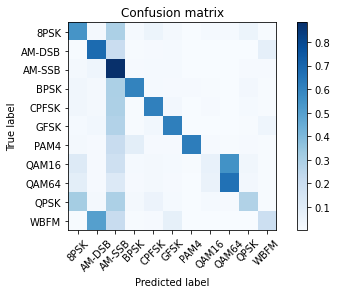

In [8]:

# Plot confusion matrix for the whole dataset
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


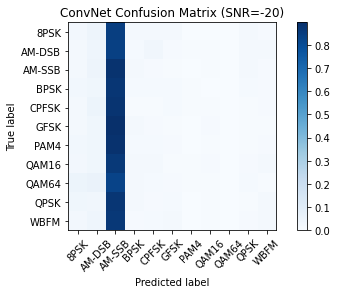

Overall Accuracy:  0.08913397215693365


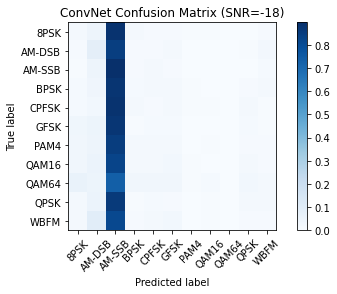

Overall Accuracy:  0.09413246940244781


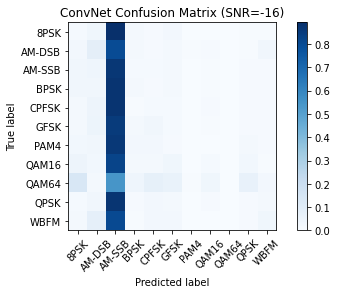

Overall Accuracy:  0.09854545454545455


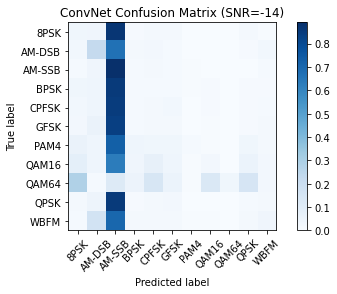

Overall Accuracy:  0.11938125568698817


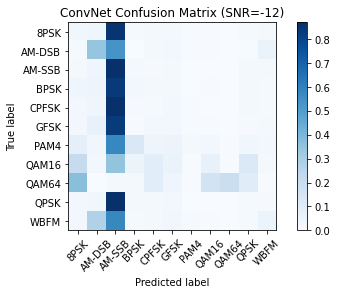

Overall Accuracy:  0.14512886126850666


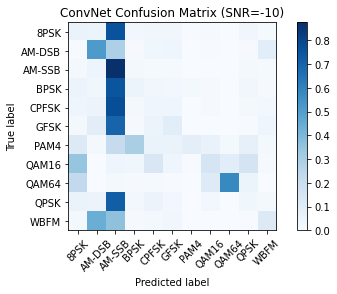

Overall Accuracy:  0.23851399856424982


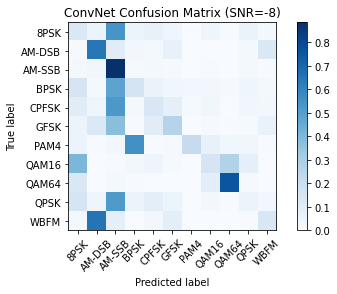

Overall Accuracy:  0.31885125184094254


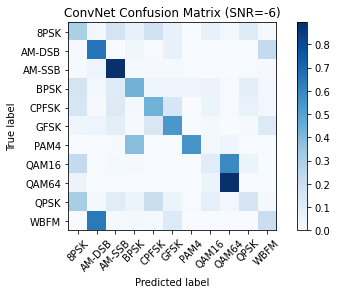

Overall Accuracy:  0.4665837184500533


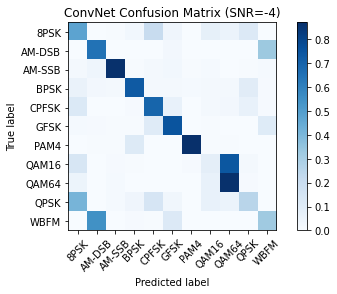

Overall Accuracy:  0.5965982621556665


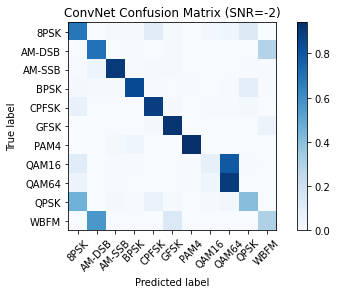

Overall Accuracy:  0.6933797909407665


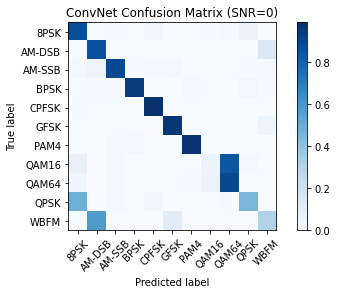

Overall Accuracy:  0.7491321030513429


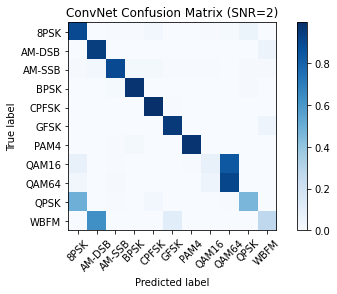

Overall Accuracy:  0.7566436112122316


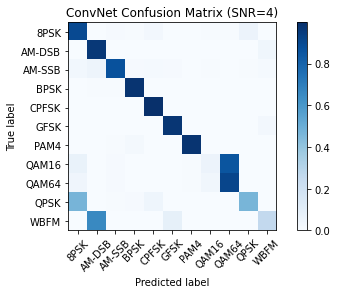

Overall Accuracy:  0.7600361663652803


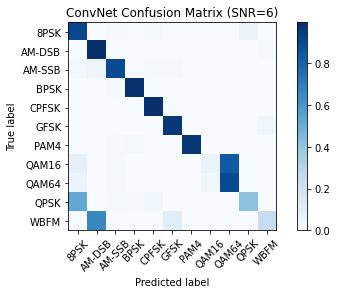

Overall Accuracy:  0.7543056064492488


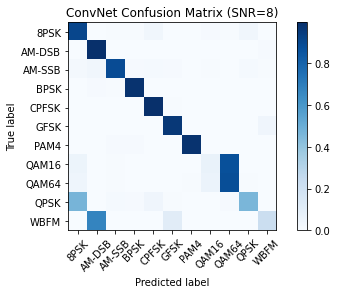

Overall Accuracy:  0.7547378104875805


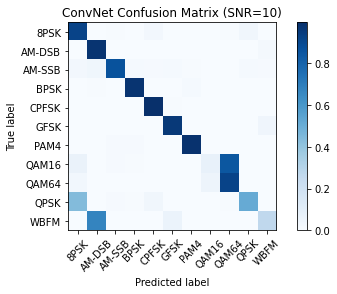

Overall Accuracy:  0.7697763229678123


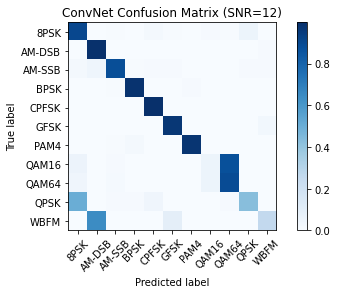

Overall Accuracy:  0.7558828812645949


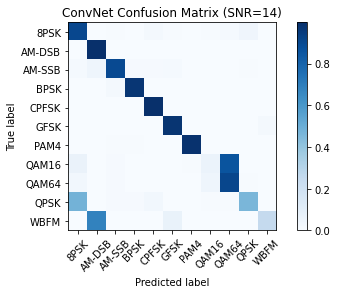

Overall Accuracy:  0.762269658821383


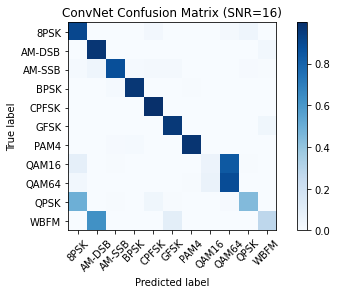

Overall Accuracy:  0.7549847314532064


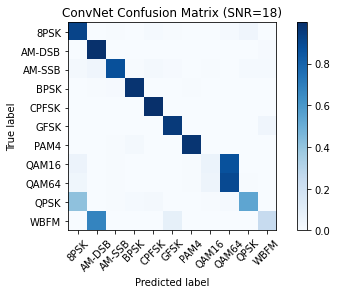

Overall Accuracy:  0.769033204916529


In [9]:
np.nan_to_num(confnorm)
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])

    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    np.nan_to_num(confnorm)
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)